In [2]:
import pandas as pd
import numpy as np
from sklearn.impute import KNNImputer
import ast
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.cluster.hierarchy import dendrogram, linkage
from scipy.spatial.distance import pdist
from sklearn.preprocessing import StandardScaler
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.decomposition import PCA

## I) Data Cleaning 

In [3]:
pd.set_option('display.max_columns', 100)
general_data_df = pd.read_csv('/Users/tranminu/Documents/spotify-mood-analyze/data/general_data.csv')
# fix the logical for the genres data
general_data_df['new_genres'] = general_data_df['genres'].apply(
    lambda x: None if ast.literal_eval(x) ==[] else ast.literal_eval(x)
)
# adding collapse columns based on the amount artist for song 
general_data_df['collapse'] = general_data_df['Artist'].apply(
    lambda x: 1 if pd.notna(x) and len(ast.literal_eval(x)) > 1 else 0
)
# encoding explicit columns 
general_data_df['explicit'] = general_data_df['explicit'].apply(
    lambda x: 0 if str(x) == 'False' else 1)
display(general_data_df.head(5))

,Unnamed: 0,year,collection_date,collection_timestamp,playlist_rank,playlist_name,track_id,track_name,artist_id,artist_name,album_name,album_release_date,duration_ms,popularity,explicit,UUID,Artist,id_x,href,isrc,acousticness,danceability,energy,instrumentalness,key,liveness,loudness,mode,speechiness,tempo,valence,id_y,follower,artist_popularity,genres,new_genres,collapse
0,0,2010,2026-01-05,2026-01-05T22:18:16.705091,1,Top Hits of 2010,2H1047e0oMSj10dgp7p2VG,I Gotta Feeling,1yxSLGMDHlW21z4YXirZDS,Black Eyed Peas,THE E.N.D. (THE ENERGY NEVER DIES),2009-01-01,289133,78,0,a294ffee-cfbc-4824-b0e8-cc6d9fa846b2,['Black Eyed Peas'],a294ffee-cfbc-4824-b0e8-cc6d9fa846b2,https://open.spotify.com/track/2H1047e0oMSj10d...,USUM70965169,0.08730,0.744,0.766,0.000000,0.0,0.5090,-6.375,1.0,0.0265,127.966,0.610,1yxSLGMDHlW21z4YXirZDS,9860987,84,[],None,0
1,1,2010,2026-01-05,2026-01-05T22:18:16.705118,2,Top Hits of 2010,7BqBn9nzAq8spo5e7cZ0dJ,Just the Way You Are,0du5cEVh5yTK9QJze8zA0C,Bruno Mars,Doo-Wops & Hooligans,2010-05-11,220734,86,0,b184f2a6-786e-4f4f-a38a-ead4c6eacfa3,"['Bruno Mars', 'Wayne Martin']",b184f2a6-786e-4f4f-a38a-ead4c6eacfa3,https://open.spotify.com/track/7BqBn9nzAq8spo5...,USAT21001269,0.01340,0.635,0.841,0.000000,5.0,0.0622,-5.379,1.0,0.0422,109.021,0.424,0du5cEVh5yTK9QJze8zA0C,77604174,92,[],None,1
2,2,2010,2026-01-05,2026-01-05T22:18:16.705130,3,Top Hits of 2010,15JINEqzVMv3SvJTAXAKED,Love The Way You Lie,7dGJo4pcD2V6oG8kP0tJRR,Eminem,Recovery,2010-06-18,263373,88,1,cd9fa892-9d52-4062-970b-46540c9fe933,"['Eminem', 'Rihanna', 'Eminen Feat Rihanna']",cd9fa892-9d52-4062-970b-46540c9fe933,https://open.spotify.com/track/15JINEqzVMv3SvJ...,USUM71015397,0.24100,0.749,0.925,0.000000,10.0,0.5200,-5.034,1.0,0.2270,86.989,0.641,7dGJo4pcD2V6oG8kP0tJRR,106423278,91,"['rap', 'hip hop']","[rap, hip hop]",1
3,3,2010,2026-01-05,2026-01-05T22:18:16.705140,4,Top Hits of 2010,0SiywuOBRcynK0uKGWdCnn,Bad Romance,1HY2Jd0NmPuamShAr6KMms,Lady Gaga,The Fame Monster (Deluxe Edition),2009-11-05,294573,86,1,5a437c94-1634-4d81-b4ce-009ab08294e9,['Lady Gaga'],5a437c94-1634-4d81-b4ce-009ab08294e9,https://open.spotify.com/track/0SiywuOBRcynK0u...,USUM70918596,0.00314,0.695,0.921,0.000053,0.0,0.0842,-3.752,1.0,0.0363,119.007,0.714,1HY2Jd0NmPuamShAr6KMms,43889739,91,"['art pop', 'pop']","[art pop, pop]",0
4,4,2010,2026-01-05,2026-01-05T22:18:16.705150,5,Top Hits of 2010,2oENJa1T33GJ0w8dC167G4,Fire Burning,6S0dmVVn4udvppDhZIWxCr,Sean Kingston,Tomorrow,2009-09-07,239986,74,0,2d8a0a7c-a9d4-479e-a459-828f0959e0b9,"['Sean Kingston', 'RedOne', 'Pitbull', 'Red One']",2d8a0a7c-a9d4-479e-a459-828f0959e0b9,https://open.spotify.com/track/2oENJa1T33GJ0w8...,USSM10902107,0.01920,0.839,0.804,0.000000,1.0,0.3310,-2.513,1.0,0.0329,122.973,0.888,6S0dmVVn4udvppDhZIWxCr,3879925,74,[],None,1


In [4]:
# droping unnecessary columns 
drop_columns = ['Unnamed: 0', 'collection_date', 'collection_timestamp',
       'playlist_rank', 'playlist_name', 'track_id', 'artist_id', 'genres',
       'artist_name', 'album_name', 'UUID', 'id_x', 'href', 'isrc',
       'id_y', 'Artist']

try:
    print('Dropping uneccesary columns')
    general_data_df = general_data_df.drop(columns = drop_columns)
except:
    print(f'Dataframe already in correct format')
    pass

print()
print(f'='*20)
print(f'Data overall')
print(f'='*20)
display(general_data_df.describe())

print()
print(f'='*20)
print(f'Dataframe shape')
print(f'='*20)
print(f'Number of columns: {general_data_df.shape[1]}')
print(f'Number of observations: {general_data_df.shape[0]}')

print()
print(f'='*20)
print(f'Missing values')
print(f'='*20)
print('Missing values by count')
display(general_data_df.isna().sum())
print()
print('Missing values in percent')
display(general_data_df.isna().sum() / general_data_df.shape[0])

print()
print('List of columns contain null values:')
col_with_null = general_data_df.columns[general_data_df.isnull().any()].tolist()
print(col_with_null)


Dropping uneccesary columns

Data overall


,year,duration_ms,popularity,explicit,acousticness,danceability,energy,instrumentalness,key,liveness,loudness,mode,speechiness,tempo,valence,follower,artist_popularity,collapse
count,1367.000000,1367.000000,1367.000000,1367.000000,1201.000000,1201.000000,1201.000000,1201.000000,1201.000000,1201.000000,1201.000000,1201.000000,1201.000000,1201.000000,1201.000000,1.367000e+03,1367.000000,1367.000000
mean,2016.926847,213773.687637,65.141185,0.347476,0.185316,0.665208,0.664103,0.011071,5.233139,0.172454,-5.961982,0.577019,0.095531,121.307386,0.504113,3.162997e+07,80.798098,0.370154
std,4.469572,42120.420774,22.775622,0.476343,0.223644,0.136172,0.163956,0.075872,3.646770,0.125804,2.099955,0.494238,0.089169,27.100302,0.228859,3.818624e+07,10.970087,0.483022
min,2010.000000,78200.000000,0.000000,0.000000,0.000041,0.188000,0.056500,0.000000,0.000000,0.021000,-17.843000,0.000000,0.022500,64.934000,0.035000,4.205000e+03,31.000000,0.000000
25%,2013.000000,188998.500000,62.000000,0.000000,0.023500,0.582000,0.561000,0.000000,2.000000,0.093900,-7.088000,0.000000,0.040100,99.990000,0.331000,4.430994e+06,74.000000,0.000000
50%,2017.000000,211975.000000,72.000000,0.000000,0.090100,0.675000,0.679000,0.000000,5.000000,0.121000,-5.664000,1.000000,0.057100,121.020000,0.507000,1.310886e+07,82.000000,0.000000
75%,2021.000000,233753.000000,79.000000,1.000000,0.255000,0.759000,0.787000,0.000053,8.000000,0.214000,-4.498000,1.000000,0.109000,138.111000,0.687000,4.580879e+07,88.000000,1.000000
max,2024.000000,613026.000000,96.000000,1.000000,0.965000,0.965000,0.976000,0.901000,11.000000,0.979000,-0.740000,1.000000,0.555000,205.863000,0.976000,1.493366e+08,100.000000,1.000000



Dataframe shape
Number of columns: 21
Number of observations: 1367

Missing values
Missing values by count


year                    0
track_name              0
album_release_date      0
duration_ms             0
popularity              0
explicit                0
acousticness          166
danceability          166
energy                166
instrumentalness      166
key                   166
liveness              166
loudness              166
mode                  166
speechiness           166
tempo                 166
valence               166
follower                0
artist_popularity       0
new_genres            802
collapse                0
dtype: int64


Missing values in percent


year                  0.000000
track_name            0.000000
album_release_date    0.000000
duration_ms           0.000000
popularity            0.000000
explicit              0.000000
acousticness          0.121434
danceability          0.121434
energy                0.121434
instrumentalness      0.121434
key                   0.121434
liveness              0.121434
loudness              0.121434
mode                  0.121434
speechiness           0.121434
tempo                 0.121434
valence               0.121434
follower              0.000000
artist_popularity     0.000000
new_genres            0.586686
collapse              0.000000
dtype: float64


List of columns contain null values:
['acousticness', 'danceability', 'energy', 'instrumentalness', 'key', 'liveness', 'loudness', 'mode', 'speechiness', 'tempo', 'valence', 'new_genres']


In [5]:
# droping columns have more than 50% null values 
try:
    print('Dropping genres column')
    general_data_df = general_data_df.drop(columns = ['new_genres'])
    col_with_null.remove('new_genres')

except:
    print(f'Dataframe already in correct format')
    pass

# KNN imputer for the fitting null values 
print()
print(f'='*20)
print(f'Filling null values')
print(f'='*20)

uncleaned_data  = general_data_df[col_with_null]
imputer = KNNImputer(n_neighbors= 5)
cleaned_numeric_data = pd.DataFrame(imputer.fit_transform(uncleaned_data), columns = col_with_null)

# combined back to the origin data 
general_data_df[col_with_null] = cleaned_numeric_data[col_with_null] 

print()
print(f'='*20)
print(f'Null values summary after knn')
print(f'='*20)

display(general_data_df.isna().sum())

Dropping genres column

Filling null values

Null values summary after knn


year                  0
track_name            0
album_release_date    0
duration_ms           0
popularity            0
explicit              0
acousticness          0
danceability          0
energy                0
instrumentalness      0
key                   0
liveness              0
loudness              0
mode                  0
speechiness           0
tempo                 0
valence               0
follower              0
artist_popularity     0
collapse              0
dtype: int64

## Data Visualization

#### I) Realtionship between numerical data 

Realtionship between numerical values


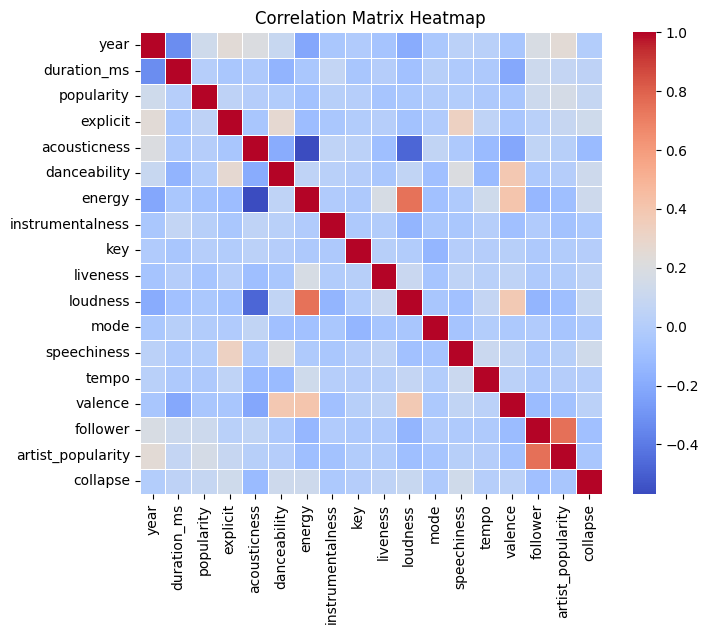


Realtionship between numerical values correspond to popularity


popularity           1.000000
artist_popularity    0.166249
year                 0.130820
follower             0.121178
collapse             0.086279
explicit             0.045138
instrumentalness     0.018465
duration_ms          0.012183
key                  0.010172
acousticness         0.006198
speechiness         -0.000216
mode                -0.005228
danceability        -0.008610
tempo               -0.024977
loudness            -0.041986
valence             -0.053594
liveness            -0.056792
energy              -0.075199
Name: popularity, dtype: float64

In [6]:
numeric_columns = ['year', 'duration_ms', 'popularity',
       'explicit', 'acousticness', 'danceability', 'energy',
       'instrumentalness', 'key', 'liveness', 'loudness', 'mode',
       'speechiness', 'tempo', 'valence', 'follower', 'artist_popularity',
       'collapse']


# Correlation matrix 
corr_matrix = general_data_df[numeric_columns].corr()
plt.figure(figsize= (8,6))
sns.heatmap(data = corr_matrix,
            cmap = 'coolwarm',
            fmt = '.2f',
            square= True,
            linewidths= .5)

plt.title('Correlation Matrix Heatmap')
print(f'='*20)
print(f'Realtionship between numerical values')
print(f'='*20)
plt.show()
print()

# correlation matrix with only popularity values
corr_matrix_poppularity = general_data_df[numeric_columns].corr()['popularity']
print(f'='*20)
print(f'Realtionship between numerical values correspond to popularity')
print(f'='*20)
display(corr_matrix_poppularity.sort_values(ascending= False))



**Correlation Analysis Results**

---

**General Observations**

There are **significant positive relationships** between:
- Loudness and Energy
- Follower count and Artist Popularity

There are **negative relationships** between:
- Acousticness and Energy
- Loudness and Acousticness

---

**Corresponding to Popularity**

None of the other numerical features show a significant strong relationship with popularity. All correlations fall between **weak to moderate** range.

Checking for hirechical relationhsip between features


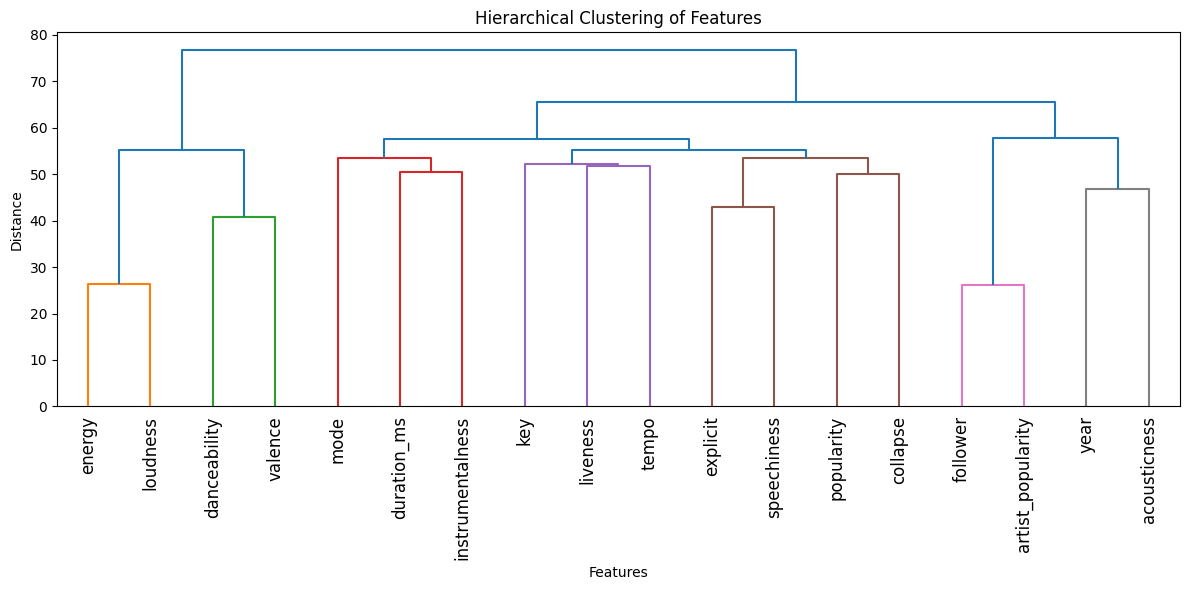


Checking for muticolinear between features


,Feature,VIF
6,energy,2.996799
10,loudness,2.474046
16,artist_popularity,2.443783
15,follower,2.366336
4,acousticness,1.643865
14,valence,1.569623
5,danceability,1.492059
0,year,1.416979
3,explicit,1.320149
1,duration_ms,1.255475



Checking for neccesary number of features


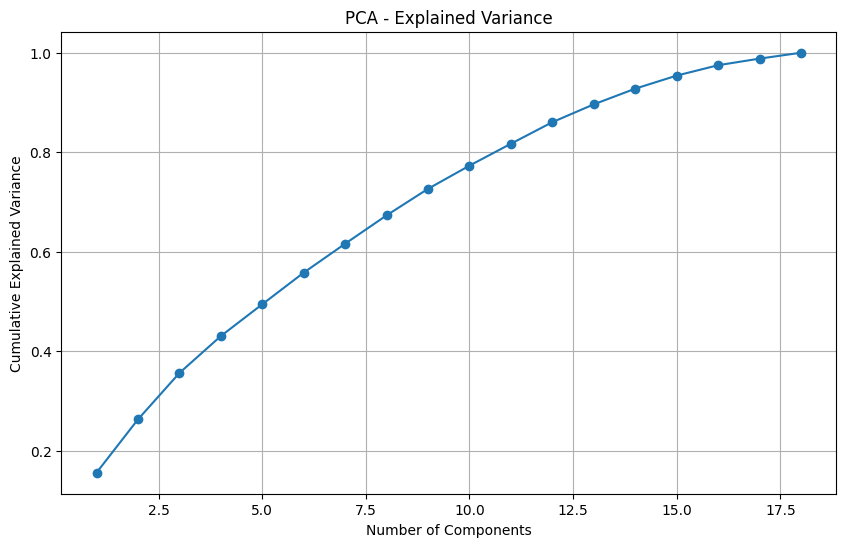

In [7]:
### Checking for multicolinear or hirechical relationship 

# Hirechical relatiohship
print(f'='*20)
print(f'Checking for hirechical relationhsip between features')
print(f'='*20)
scaled_data = StandardScaler().fit_transform(general_data_df[numeric_columns])
linkage_matrix = linkage(scaled_data.T, method = 'ward')

plt.figure(figsize=(12, 6))
dendrogram(linkage_matrix, labels=numeric_columns, leaf_rotation=90)
plt.title('Hierarchical Clustering of Features')
plt.xlabel('Features')
plt.ylabel('Distance')
plt.tight_layout()
plt.show()
print()


# Checking for multicolinear 
scaled_data_df = pd.DataFrame(scaled_data, columns= numeric_columns)
vif_data = pd.DataFrame()
vif_data['Feature'] = numeric_columns
vif_data['VIF'] = [variance_inflation_factor(scaled_data_df.values,i) for i in range(len(numeric_columns))]
print(f'='*20)
print(f'Checking for muticolinear between features')
print(f'='*20)
display(vif_data.sort_values('VIF', ascending= False))
print()

# PCA
pca = PCA(n_components= len(numeric_columns))
pca_features = pca.fit(scaled_data)

print(f'='*20)
print(f'Checking for neccesary number of features')
print(f'='*20)

plt.figure(figsize=(10, 6))
plt.plot(range(1, len(pca.explained_variance_ratio_) + 1), 
         pca.explained_variance_ratio_.cumsum(), marker='o')
plt.xlabel('Number of Components')
plt.ylabel('Cumulative Explained Variance')
plt.title('PCA - Explained Variance')
plt.grid()
plt.show()



**Hirechical cluster**

There are only 2 clode relatiohsip:

- Energy and Loudness
- Follower and Artist popularity 

But not considered to be hirechical related 

---

**Multicolinear(VIF)**

There is no observation of multicolinear relationship, VIF of all features smaller than 5

---

**PCA Components**

All features is fairly share the same amount of important, while it is required more than 14 out of 18 to explain 90% of variance. It is not possible to reduce the current dimension to a lower dimension

---

In general, All features are linear independence, and have the same weight for the variance of the data.

#### Outlier detection

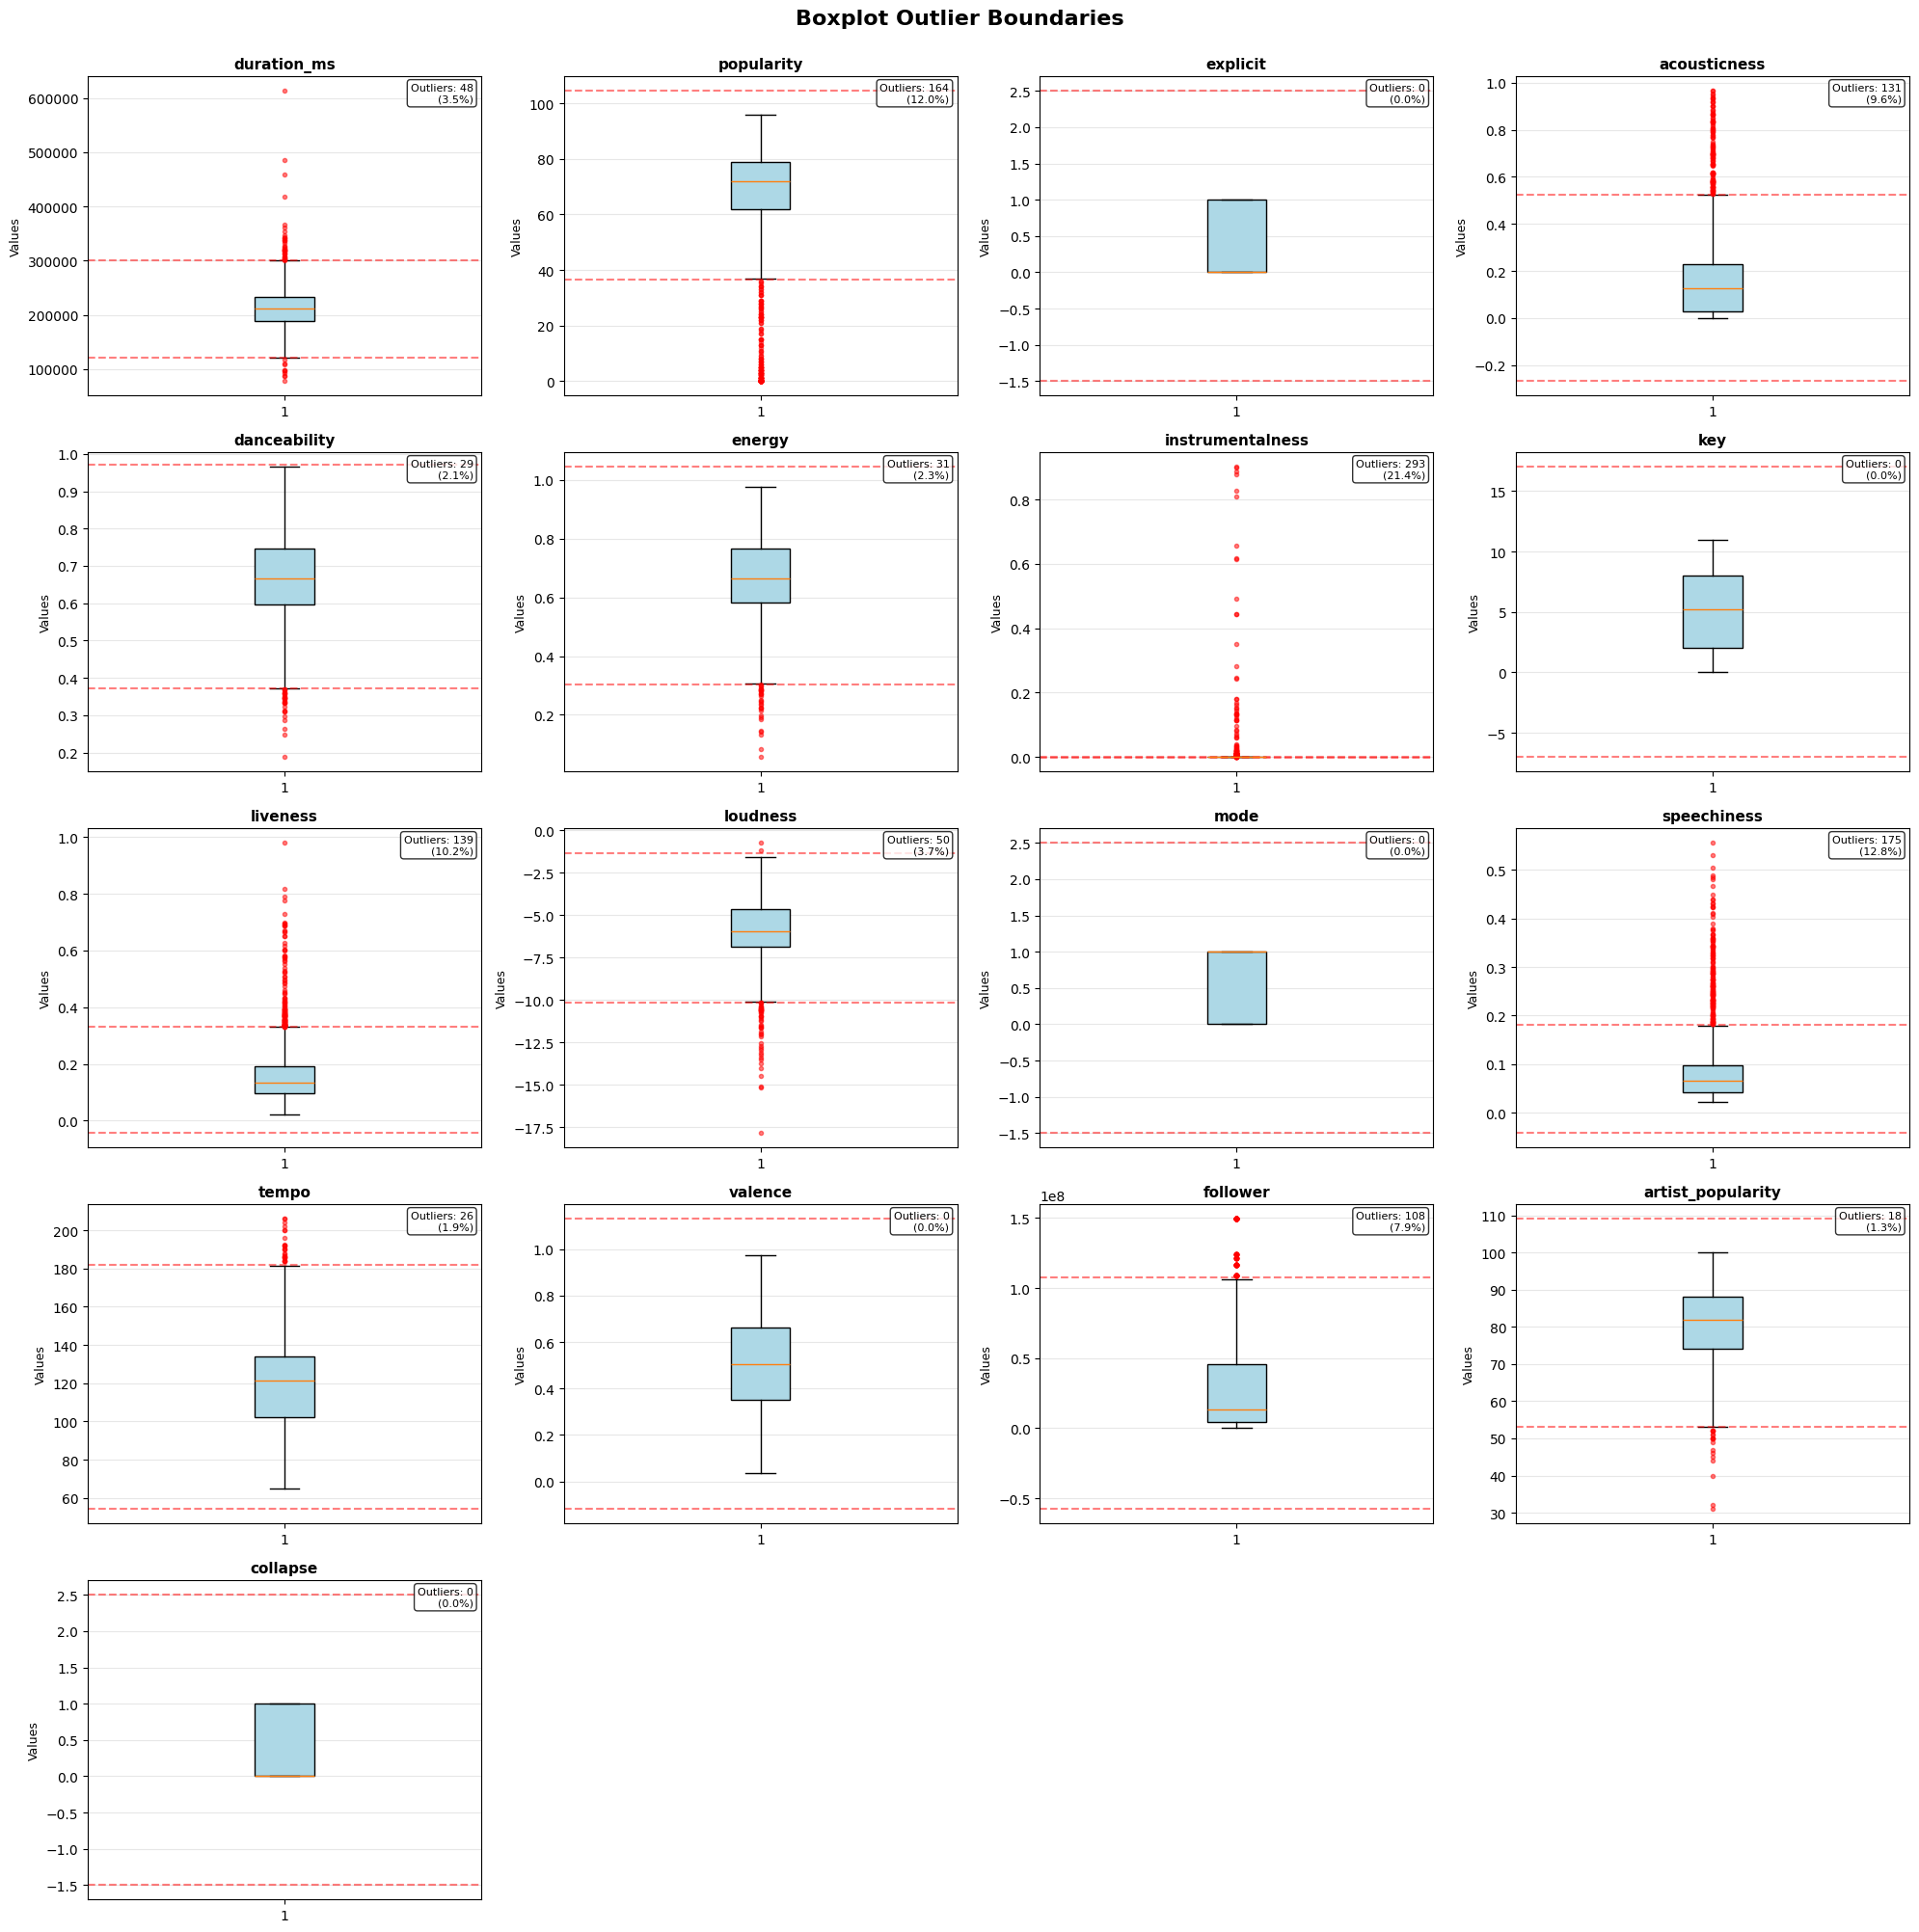

In [8]:
outlier_detect_cols = numeric_columns.copy()
outlier_detect_cols.remove('year')

# outlier detection using IQR method 

# Finding Q1,Q3 and corresponding upper bound and lower bound
outlier_detect_df = general_data_df[outlier_detect_cols].describe().T[['25%', '50%', '75%','max']]
outlier_detect_df['lb'] = outlier_detect_df['25%'] - 1.5 * (outlier_detect_df['75%'] - outlier_detect_df['25%'])
outlier_detect_df['ub'] = outlier_detect_df['75%'] + 1.5 * (outlier_detect_df['75%'] - outlier_detect_df['25%'])

# Create subplots
features = outlier_detect_cols
n_features = len(features)
n_cols = 4
n_rows = (n_features + n_cols - 1) // n_cols

fig, axes = plt.subplots(n_rows, n_cols, figsize=(20, n_rows * 4))
axes = axes.flatten()

# Loop through each feature
for idx, feature in enumerate(features):
    ax = axes[idx]
    
    # Get actual data for this feature
    data = general_data_df[feature].dropna()
    
    # Get statistics from stats_df
    q1 = outlier_detect_df.loc[feature, '25%']
    median = outlier_detect_df.loc[feature, '50%']
    q3 = outlier_detect_df.loc[feature, '75%']
    lower_bound = outlier_detect_df.loc[feature, 'lb']
    upper_bound = outlier_detect_df.loc[feature, 'ub']
    
    # Create boxplot using actual data
    bp = ax.boxplot(data, vert=True, patch_artist=True,
                    showfliers=True,  # Show outliers as points
                    flierprops=dict(marker='o', markerfacecolor='red', 
                                   markersize=3, alpha=0.5, markeredgecolor='red'))
    
    # Color the box
    for patch in bp['boxes']:
        patch.set_facecolor('lightblue')
    
    # Add outlier boundary lines from stats_df
    ax.axhline(y=lower_bound, color='red', linestyle='--', 
               alpha=0.5, linewidth=1.5, label='Lower Bound')
    ax.axhline(y=upper_bound, color='red', linestyle='--', 
               alpha=0.5, linewidth=1.5, label='Upper Bound')
    
    # Calculate number of outliers
    outliers = data[(data < lower_bound) | (data > upper_bound)]
    outlier_pct = (len(outliers) / len(data)) * 100
    
    # Title and labels
    ax.set_title(f'{feature}', fontsize=11, fontweight='bold')
    ax.set_ylabel('Values', fontsize=9)
    ax.grid(True, alpha=0.3, axis='y')
    
    # Add outlier count annotation
    ax.text(0.98, 0.98, f'Outliers: {len(outliers)}\n({outlier_pct:.1f}%)', 
            transform=ax.transAxes,
            fontsize=8, verticalalignment='top', horizontalalignment='right',
            bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))

# Remove empty subplots
for idx in range(n_features, len(axes)):
    fig.delaxes(axes[idx])

plt.suptitle('Boxplot Outlier Boundaries',  
             fontsize=16, 
             fontweight='bold',
             verticalalignment='top',y =1)
plt.tight_layout()
plt.show()

**Outlier Detection**

- Most features are observed to be normalized except for valence, collapse, key and explicit.
- Extremely high percent out;ier features: instrumentainess, 21.4%
- High percent of outlier features: popularity, speechness and liveness, with the percent of outlier are 12%, 12.8% and 10.2, respectively
- Moderate percent of outlier features: acousticness, followers, 9.6 and 7.9 %
- Low percent of outlier features: duration, danceability, energy, loudness, tempo, artist popularity, approximately 2%. 

#### Trend visualization

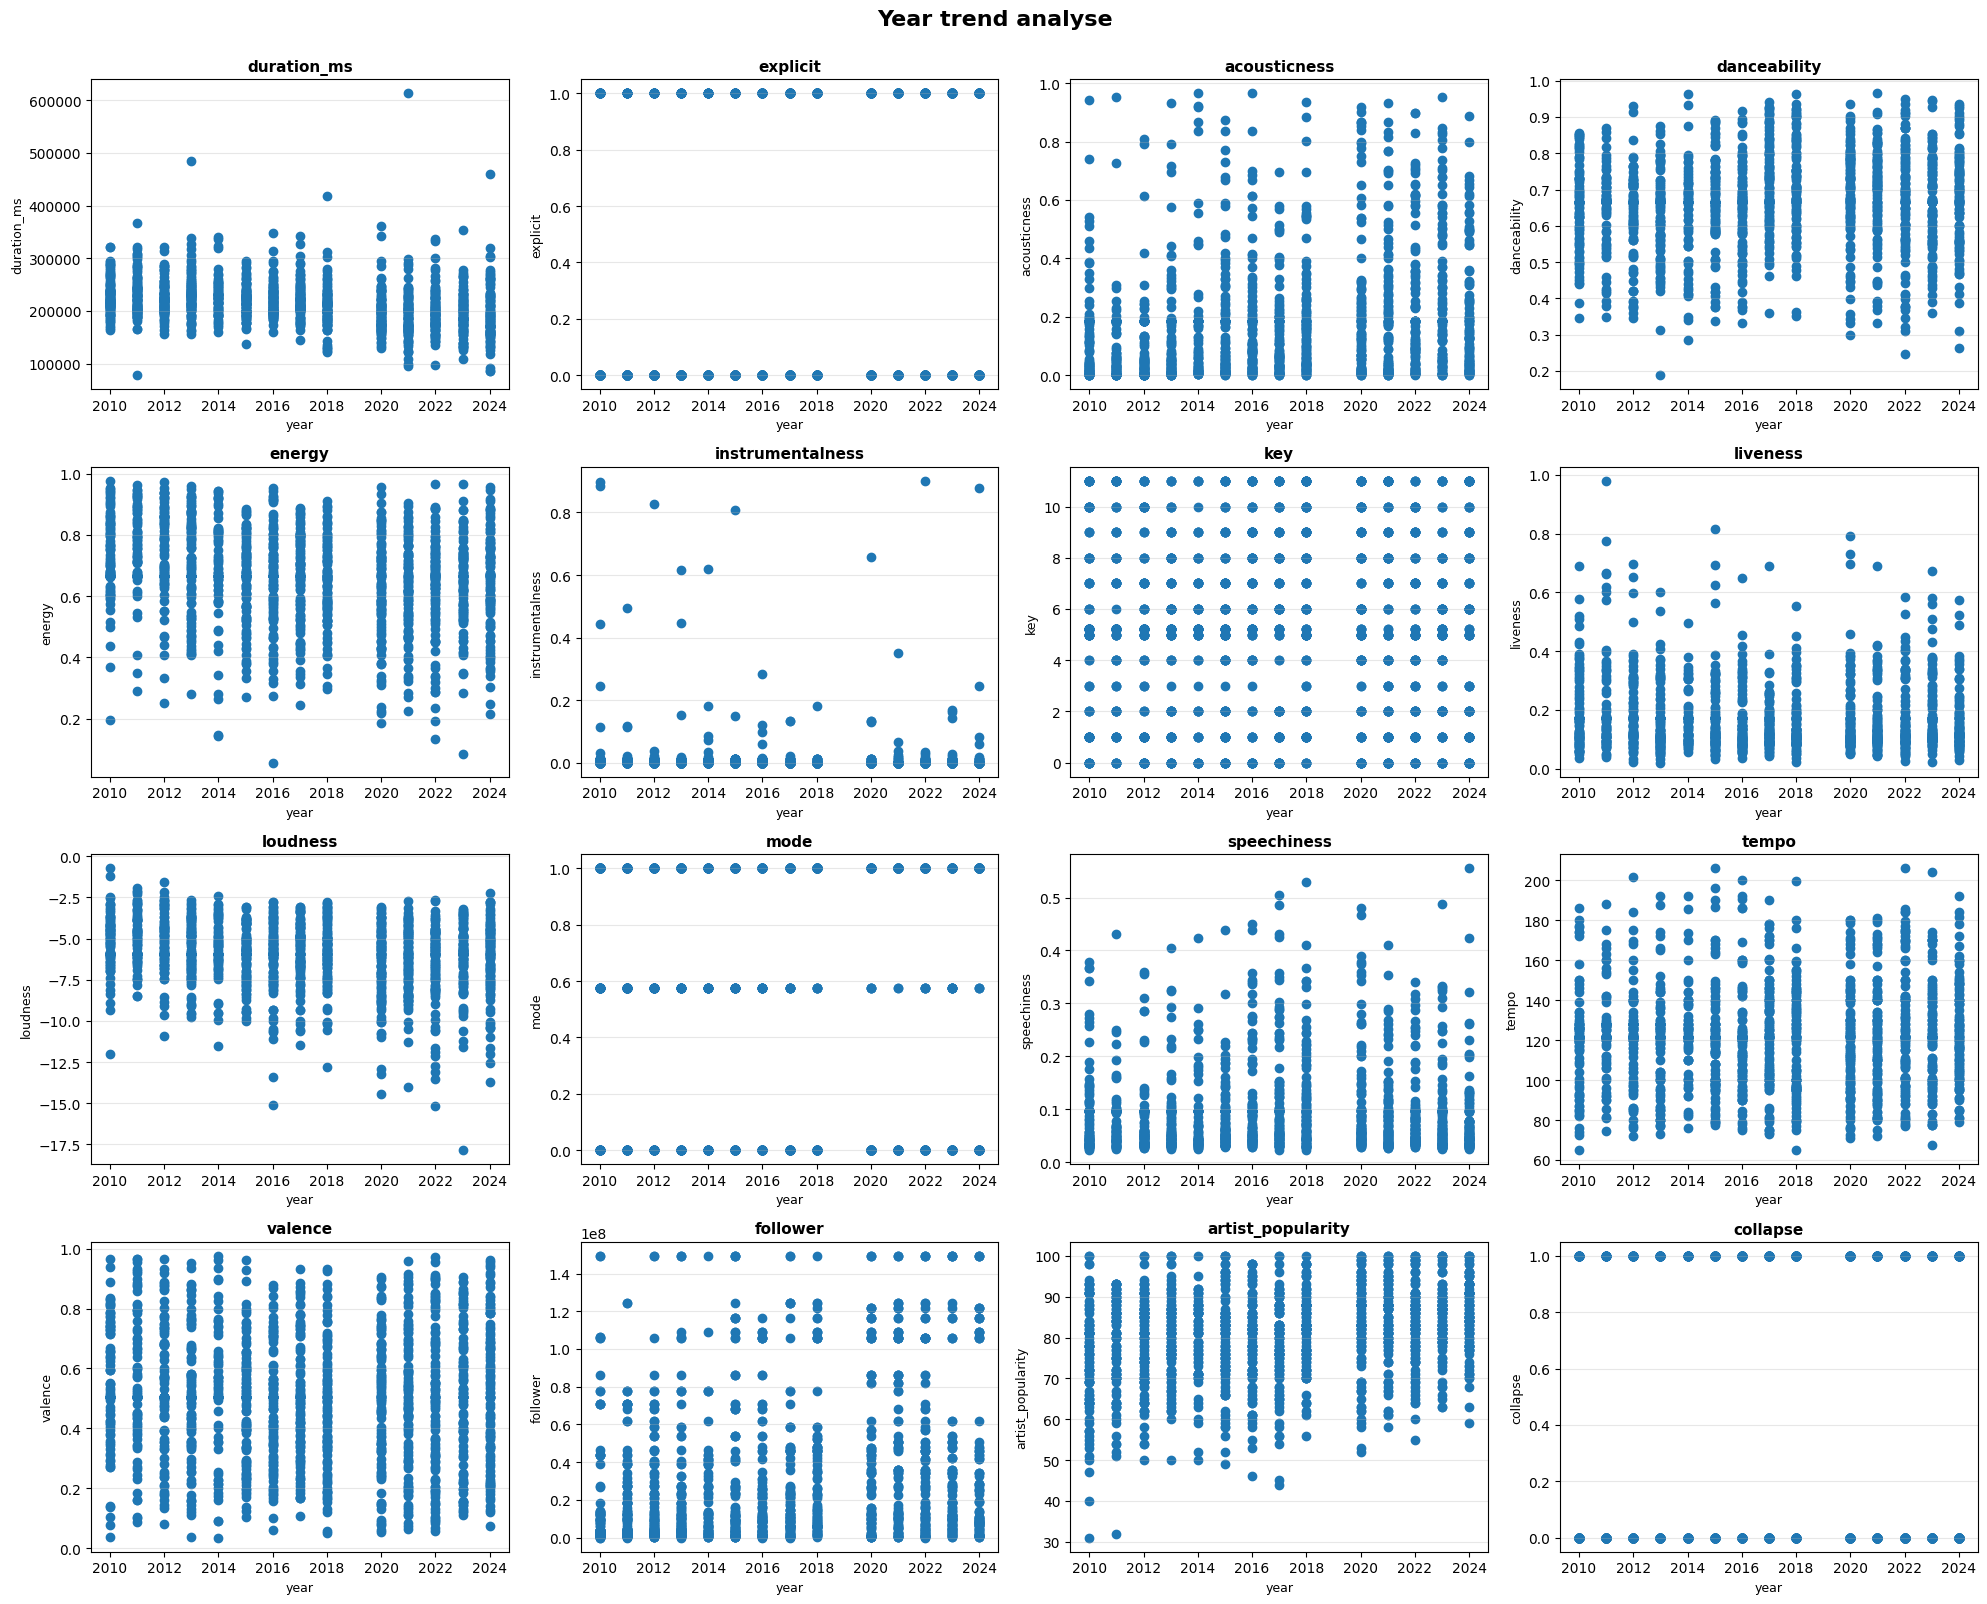


Correlation of features according to year


year                 1.000000
artist_popularity    0.250291
explicit             0.245075
acousticness         0.202281
follower             0.182233
popularity           0.130820
danceability         0.098611
speechiness          0.033797
tempo                0.024894
collapse            -0.002708
key                 -0.012837
mode                -0.041668
instrumentalness    -0.045728
valence             -0.053672
liveness            -0.063219
loudness            -0.189774
energy              -0.219520
duration_ms         -0.327265
Name: year, dtype: float64

In [20]:
# According to year
analyze_column = ['duration_ms',
       'explicit', 'acousticness', 'danceability', 'energy',
       'instrumentalness', 'key', 'liveness', 'loudness', 'mode',
       'speechiness', 'tempo', 'valence', 'follower', 'artist_popularity',
       'collapse']
n_trend_feature = len(analyze_column)
n_cols = 4  
n_rows = (n_trend_feature + n_cols - 1) // n_cols

fig, axes = plt.subplots(n_rows, n_cols, figsize=(20, n_rows * 4))
axes = axes.flatten()

for idx, feature in enumerate(analyze_column):
    ax = axes[idx]

    ax.scatter(general_data_df['year'], general_data_df[feature])
    
    # Title and labels
    ax.set_title(f'{feature}', fontsize=11, fontweight='bold')
    ax.set_xlabel(xlabel = 'year', fontsize = 9)
    ax.set_ylabel(ylabel = str(feature), fontsize=9)
    ax.grid(True, alpha=0.3, axis='y')


# Remove empty subplots
for idx in range(n_features, len(axes)):
    fig.delaxes(axes[idx])

plt.suptitle('Year trend analyse',  
             fontsize=16, 
             fontweight='bold',
             verticalalignment='top',y =1)
plt.tight_layout()
plt.show()


year_corr_matrix = general_data_df[numeric_columns].corr()['year']
print()
print(f'=' * 20)
print('Correlation of features according to year')
print(f'=' * 20)
display(year_corr_matrix.sort_values(ascending = False))

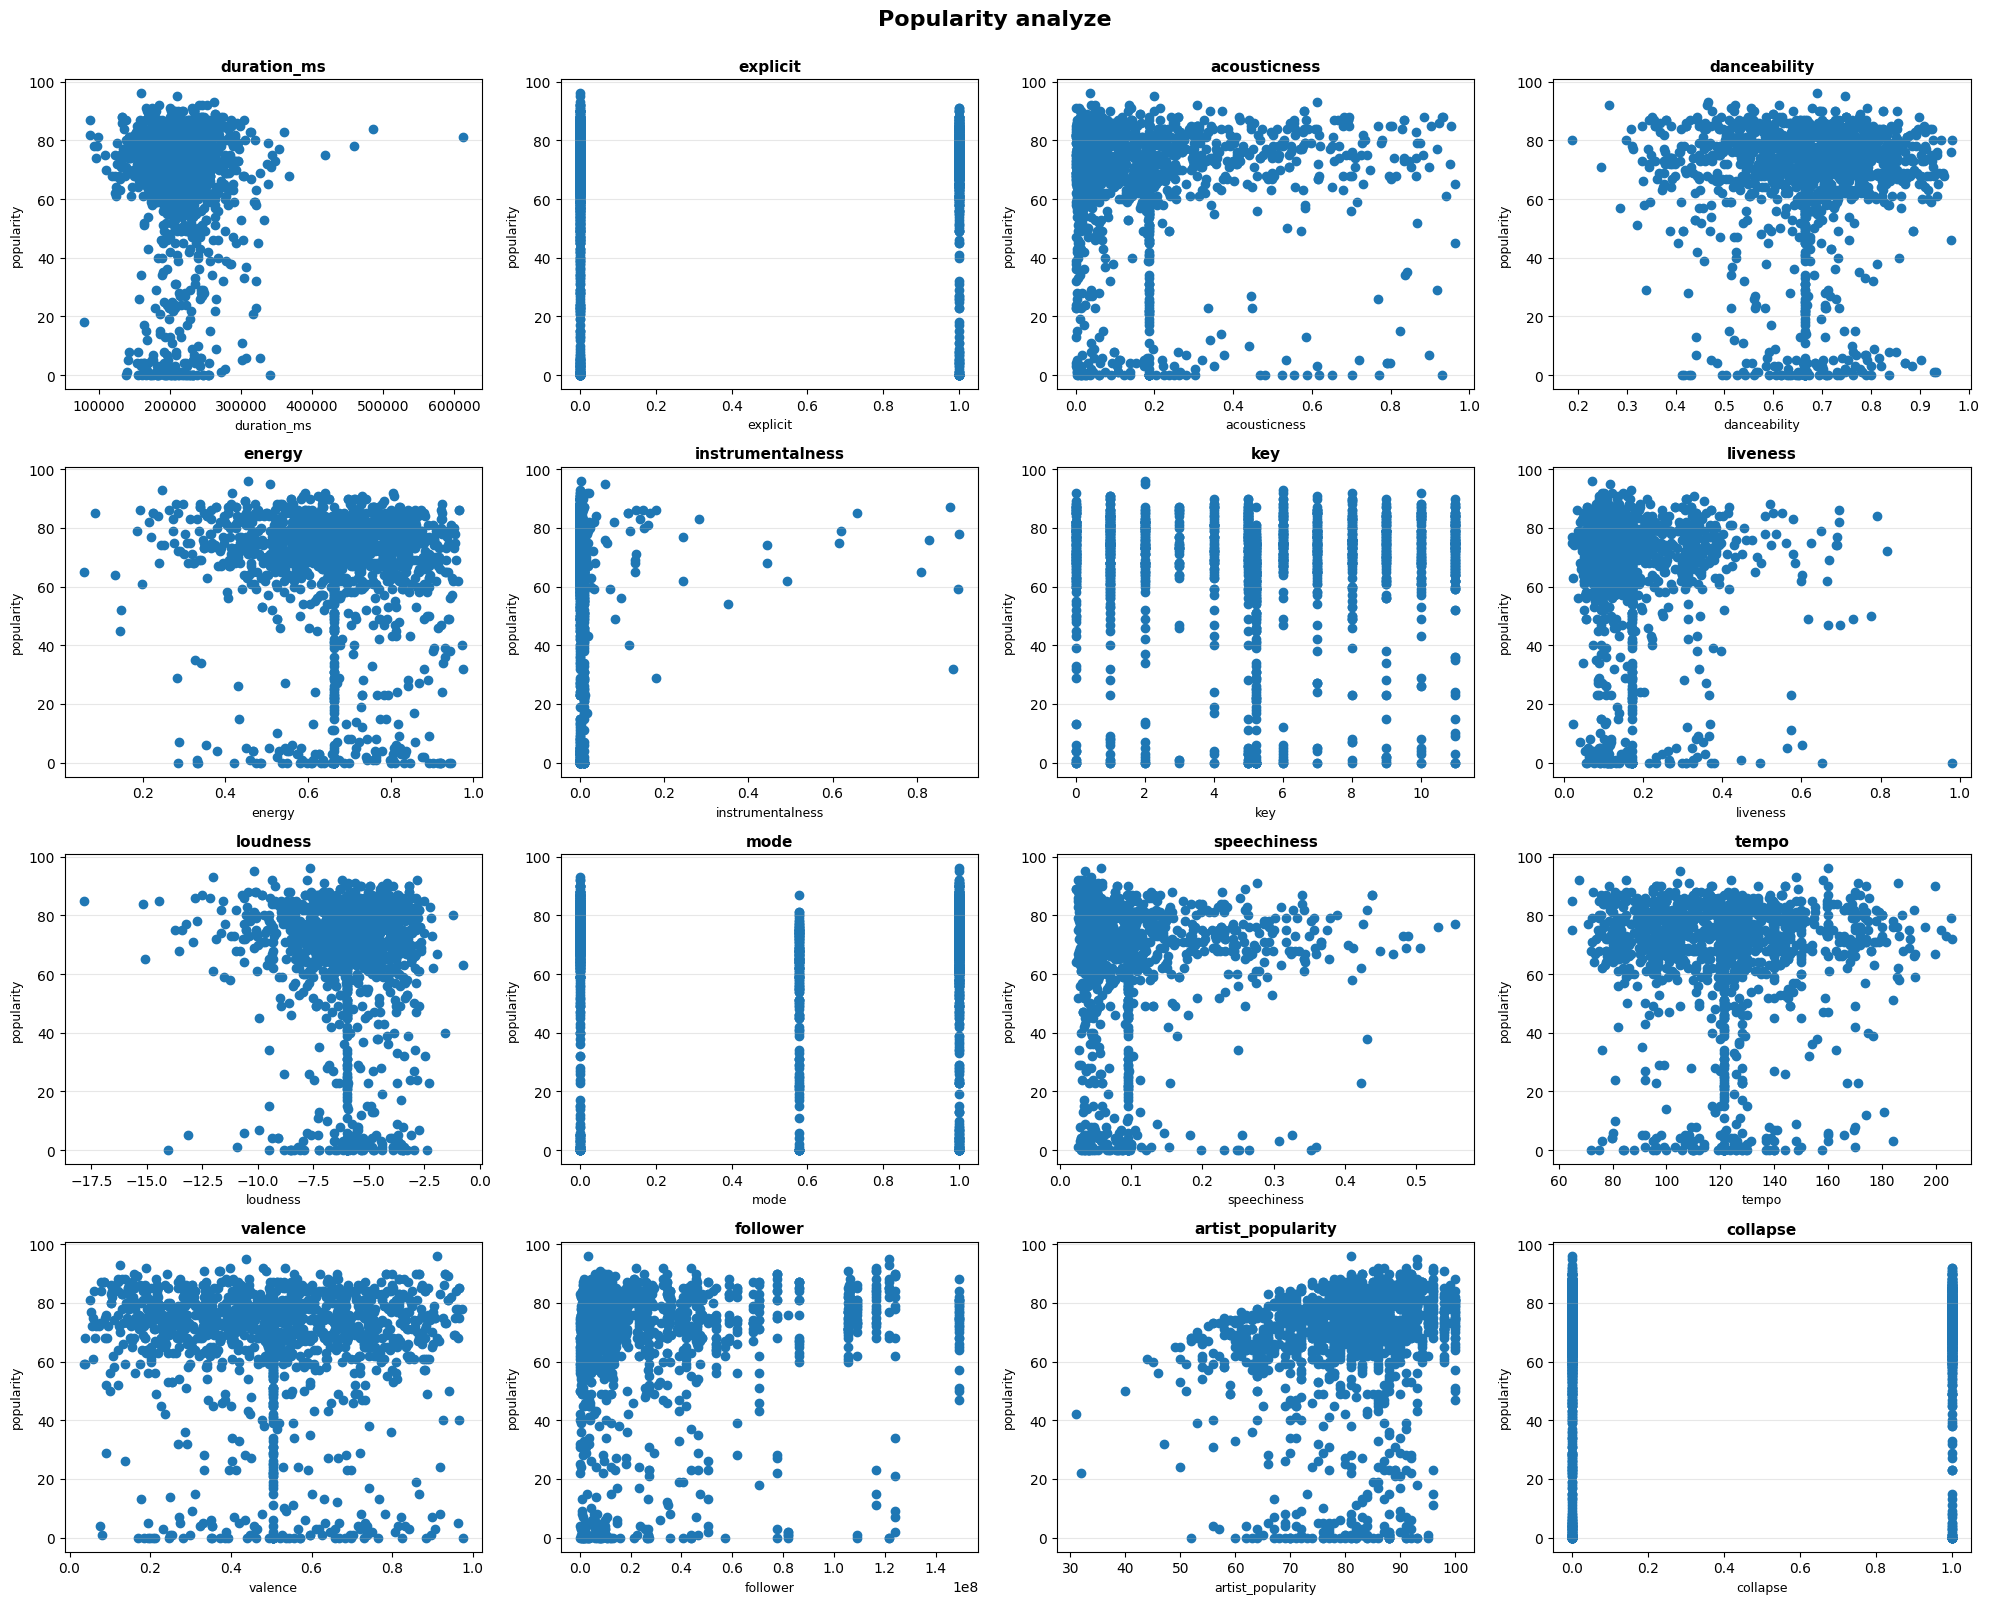


Correlation of features according to popularity


popularity           1.000000
artist_popularity    0.166249
year                 0.130820
follower             0.121178
collapse             0.086279
explicit             0.045138
instrumentalness     0.018465
duration_ms          0.012183
key                  0.010172
acousticness         0.006198
speechiness         -0.000216
mode                -0.005228
danceability        -0.008610
tempo               -0.024977
loudness            -0.041986
valence             -0.053594
liveness            -0.056792
energy              -0.075199
Name: popularity, dtype: float64

In [21]:
# According to popularity

fig, axes = plt.subplots(n_rows, n_cols, figsize=(20, n_rows * 4))
axes = axes.flatten()

for idx, feature in enumerate(analyze_column):
    ax = axes[idx]
    
    # Get actual data for this feature
    data = general_data_df[analyze_column]

    ax.scatter(general_data_df[feature], general_data_df['popularity'])
    
    # Title and labels
    ax.set_title(f'{feature}', fontsize=11, fontweight='bold')
    ax.set_xlabel(xlabel = str(feature), fontsize = 9)
    ax.set_ylabel(ylabel = 'popularity', fontsize=9)
    ax.grid(True, alpha=0.3, axis='y')


# Remove empty subplots
for idx in range(n_features, len(axes)):
    fig.delaxes(axes[idx])

plt.suptitle('Popularity analyze',  
             fontsize=16, 
             fontweight='bold',
             verticalalignment='top',y =1)
plt.tight_layout()
plt.show()


year_corr_matrix = general_data_df[numeric_columns].corr()['popularity']
print()
print(f'=' * 20)
print('Correlation of features according to popularity')
print(f'=' * 20)
display(year_corr_matrix.sort_values(ascending = False))

**Year Analyze**

- Strongly positive: Artist Popularity, Explicit, Aucousticness
- Strongly Negeative: Duration, Energy, Loudness
- General: the distribution for the observation of features have remained table through years

**Popularity Analyze**

- Positive: artist_popularity, year, follower
- General: Most features remain the same distribution arcoding to popularity 
- The distribution of featurs are wider for low and high popularity while for moderate popularity, the distribution of features concentrate around the median value. 

**Final Analyze**

- Songs have potential to slower and less energy through year, and the content tend to be more valence. This indicate people trend to be favour in negative connotation song 
- The duration for songs also observed to be shorter, this could be affect by the trend of short videos and social media product
- The key point that make the song popular is the artist_popularity and follower. This indicate that people tend to listen to certain number of artist which make freshmans' song harder to approach with the audience
 

